# Performance Metrics


## Imports

In [1]:
# base
import math
import matplotlib.pyplot as plt
import pandas as pd

# preproc
from sklearn.preprocessing import LabelEncoder

# models
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score


## Dataset

In [2]:
# import from url
url = 'https://wagon-public-datasets.s3.amazonaws.com/insurance_ML3.csv'
data = pd.read_csv(url)

In [3]:
# sanity check
data.head(2)

,age,sex,bmi,children,smoker,region,charges,price_range
0,19,female,27.90,0,True,southwest,16884.9240,expensive
1,18,male,33.77,1,False,southeast,1725.5523,cheap


In [4]:
# prepare datasets
# simple X and y for a simple model
X = data[['age', 'bmi', 'children', 'smoker']]
y = data['charges']

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [5]:
# checking data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((936, 4), (936,), (402, 4), (402,))

## Baseline Score

In [6]:
# using the simplest regressor ever
dummy_reg = DummyRegressor(strategy = 'mean')

**Note:**   
As a data scientist, I have not used dummy models often. I tend to start with something overly simplistic and iterate from there. I still think it can be a useful first step.

In [7]:
# fit and score the dummy
dummy_reg.fit(X_train, y_train)
r2_dummy = dummy_reg.score(X_test, y_test)
print(round(r2_dummy, 3))

-0.001


We note that the default metric (with regressors: R squared) is negative; our model is doing a worse job than just predicting the mean... At least it will be easy to improve from there!

## Improving the score

In [8]:
# fit and score a linear regression model
model_linreg = LinearRegression().fit(X_train, y_train)
r2_linreg = model_linreg.score(X_test, y_test)
print(round(r2_linreg, 3))

0.769


### Create a prediction

In [9]:
# create prediction
y_pred = model_linreg.predict(X_test)

# check output
y_pred.shape

(402,)

In [10]:
# sanity check
round(y_test[:2],2)

764    9095.07
887    5272.18
Name: charges, dtype: float64

## Regression metrics

In [11]:
# compute metrics
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
rsquared = r2_score(y_test, y_pred)
max_err = max_error(y_test, y_pred) # here, we avoid using 'max' or 'max_error' as variable name, as they can overwrite methods


In [ ]:
# print values
print('MSE =', round(mse, 2))
print('RMSE =', round(rmse, 2))
print('MAE =', round(mae, 2))
print('R2 =', round(rsquared, 2))
print('Max Error =', round(max_err, 2))

MSE = 33803299.26
RMSE = 5814.06
MAE = 4141.91
R2 = 0.77
Max Error = 22730.91


In [13]:
# print using a cleaner method, which is also more escalable
metrics = {
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "R2": rsquared,
    "Max Error": max_err
}
for name, value in metrics.items():
    print(f"{name} = {round(value, 2)}")

MSE = 33803299.26
RMSE = 5814.06
MAE = 4141.91
R2 = 0.77
Max Error = 22730.91


In [14]:
# define our CV parameters
FOLDS = 5
linreg_model = LinearRegression()
list_of_metrics = ['max_error', 'r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']

# Cross Validate
cv_results = cross_validate(linreg_model, X_train, y_train, cv=FOLDS, scoring=list_of_metrics)

# create a usable output
pd.DataFrame(cv_results)

,fit_time,score_time,test_max_error,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error
0,0.005014,0.005156,-23919.541251,0.763853,-4267.159274,-3.649617e+07
1,0.042103,0.003946,-22574.654193,0.799364,-4315.976759,-3.511006e+07
2,0.015664,0.003729,-21987.247971,0.632084,-4510.593955,-4.280274e+07
3,0.003094,0.003272,-29628.368150,0.687040,-4334.002282,-4.173723e+07
4,0.002716,0.003439,-26620.341329,0.759685,-3960.307261,-3.620033e+07


### Data

In [15]:
# actual truths
truths = [0, 1, 0, 0, 1, 0, 1, 1, 0, 1]

# predictions
preds = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]

# Store results in a dataframe
results_df = pd.DataFrame({"actual": truths,
                           "predicted": preds})

In [16]:
# confusion matrix
confusion_matrix = pd.crosstab(index= results_df['actual'],
                               columns = results_df['predicted'])
confusion_matrix

predicted,0,1
actual,,
0,3,2
1,1,4


## Classification Metrics

In [17]:
# compute the metrics
print('Accuracy =', round(accuracy_score(truths, preds), 2))
print('Precision =', round(precision_score(truths, preds), 2))
print('Recall =', round(recall_score(truths, preds), 2))
print('F1 score =', round(f1_score(truths, preds), 2))

Accuracy = 0.7
Precision = 0.67
Recall = 0.8
F1 score = 0.73


# Assignment: Insurance prediction

In [18]:
# quick look at classes
data['price_range'].value_counts()

cheap        918
expensive    420
Name: price_range, dtype: int64

In [19]:
# define threshold (to change efficiently the results if the assignment change)
objective = 0.8

In [20]:
# label our target
label_enc = LabelEncoder()
label_enc.fit(data['price_range'])

LabelEncoder()

In [21]:
# original classes are still findable
label_enc.classes_

array(['cheap', 'expensive'], dtype=object)

In [22]:
# create a new column with the encoded label
data['price_range_encoded'] = label_enc.transform(data['price_range'])

# sanity check
data.sample(3)

,age,sex,bmi,children,smoker,region,charges,price_range,price_range_encoded
1166,57,male,40.37,0,False,southeast,10982.5013,cheap,0
998,33,female,36.29,3,False,northeast,6551.7501,cheap,0
416,52,male,34.10,0,False,southeast,9140.9510,cheap,0


In [23]:
# instantiate a log reg model
logreg_model = LogisticRegression()

# predict
results = cross_val_predict(logreg_model, X, data['price_range_encoded'], cv = FOLDS, method='predict_proba')

# transpose and separate
data['proba_cheap'], data['proba_expensive'] = results.T

# sanity check
data['proba_cheap'][:3], data['proba_expensive'][:3]

(0    0.072311
 1    0.958116
 2    0.912311
 Name: proba_cheap, dtype: float64,
 0    0.927689
 1    0.041884
 2    0.087689
 Name: proba_expensive, dtype: float64)

In [24]:
# [OPTIONAL CHECK] one step further:
# verify that for every row of the df, the expensive probability is the inverse of the cheap probability (binary classification)
for n in range(len(data)):
    assert data['proba_cheap'][n] == 1 - data['proba_expensive'][n]

### Create the recall curve

#### Extracting Data

In [25]:
# calling the method on the target and the probability of expensive prediction
results_curve =  precision_recall_curve(data['price_range_encoded'], data['proba_expensive'])

# sanity check
type(results_curve)

tuple

In [26]:
# creating a more structured and usable output
precision, recall, threshold = results_curve

scores = pd.DataFrame({'threshold':threshold,
                       'precision': precision[:-1],
                       'recall':recall[:-1]})
scores.head(3)

,threshold,precision,recall
0,0.023415,0.313901,1.0
1,0.023590,0.314136,1.0
2,0.024032,0.314371,1.0


Why the `[:-1]`?

This is because of the way Scikit-learn creates the data.

We observe:
- precision length = N + 1
- recall length = N + 1
- thresholds length = N   
where N = number of unique score values in y_scores.

Each threshold defines a decision rule where the model predicts a positive if score >= threshold.   
For each threshold, sklearn computes one (precision, recall) pair.

But sklearn also adds one extra point at the end with recall = 0 and precision = 1.   

This corresponds to the case where:
- the threshold is set above the maximum score
- no samples are predicted positive

That point is useful for plotting a closed precision–recall curve, but it does not correspond to any threshold.

#### Actual plotting

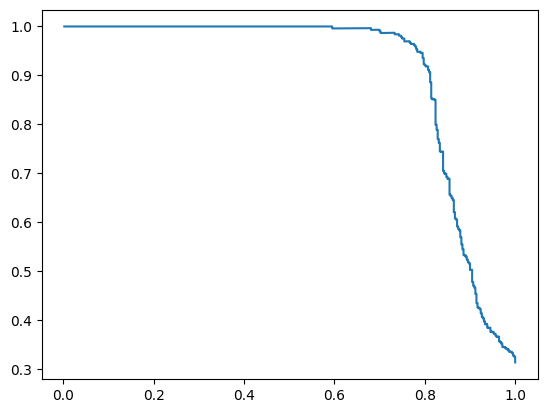

In [27]:
# plot recall against precision
plt.plot(scores['recall'], scores['precision']);

We can visualise the value where passes our threshold:

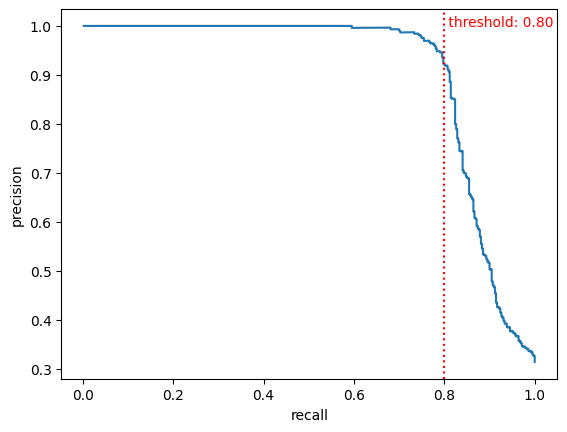

In [28]:
# metrics
plt.plot(scores['recall'], scores['precision'])

# threshold
plt.axvline(objective, linestyle = ':', color = 'red')
plt.annotate(
    f' threshold: {objective:.2f}',
    xy=(objective, 1), # coordinates of the annotation
    color='red'
)
# prettify
plt.ylabel('precision')
plt.xlabel('recall');

In [29]:
# define the maximum value where the agreed proportion of expensive customers are correctly identified
model_threshold = scores[scores['recall'] >= objective].threshold.max()

# print results
print(f'The model requires a threshold of {model_threshold:.3f} to identify at least {objective*100}% of expensive customers.')

The model requires a threshold of 0.306 to identify at least 80.0% of expensive customers.


You can rerun the analysis with a different threshold value!

## Custom model

### Define a new, custom classification model 

In [30]:
# instantiate
adjusted_model_logreg = LogisticRegression()

# fit
adjusted_model_logreg.fit(X, data['price_range_encoded'])

LogisticRegression()

In [31]:
# creating a new function to adjust the model to our threshold
def custom_predict(X, threshold, model):
    """
    Classify inputs using a fitted scikit-learn model and a custom probability threshold

    :param X (DataFrame): Feature matrix used for prediction
    :param threshold (float): Probability threshold for assigning the positive class
    :param model: Fitted model implementing ``predict_proba``

    :return (ndarray[bool]): Boolean array with predictions
    """
    probs = model.predict_proba(X)
    expensive_probs = probs[:, 1]
    y = expensive_probs > threshold

    return y.astype(int)

In [32]:
# use the function
updated_preds = custom_predict(X=X, threshold=model_threshold, model=adjusted_model_logreg)

# print the results
print("Recall:", recall_score(data['price_range_encoded'], updated_preds))
print("Precision:", precision_score(data['price_range_encoded'], updated_preds))
print("F1 Score:", f1_score(data['price_range_encoded'], updated_preds))

Recall: 0.8071428571428572
Precision: 0.9287671232876712
F1 Score: 0.8636942675159236


You can now easily check the parameters from your own function `custom_predict` thanks to the docstring :)

# ROC-AUC

<img src='https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/machine-learning/AUC_2_models.png'  width=300>

In [33]:
# Extract associated metrics (fpr: false positive rate, tpr: true positive rate) and thresholds
fpr, tpr, threshold = roc_curve(data['price_range_encoded'], data['proba_expensive'])
fpr, tpr, threshold

# making it readable
roc_scores = pd.DataFrame({'fpr':fpr,
                       'tpr': tpr,
                       'threshold':threshold})
roc_scores.sample(3)

,fpr,tpr,threshold
35,0.025054,0.795238,0.309013
112,0.371460,0.895238,0.151452
183,0.872549,0.983333,0.036435


In [34]:
# Compute AUC score
auc_score = roc_auc_score(data['price_range_encoded'], data['proba_expensive'])
round(auc_score, 3)


0.909